In [2]:
# Install required libraries if needed
%pip install psycopg2-binary pandas neo4j matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import psycopg2
import pandas as pd
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import seaborn as sns

### Connect to PostgreSQL and Neo4j

In [40]:
pg_conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="password",
    host="localhost",
    port="5432"
)
neo4j_driver = GraphDatabase.driver(
    "bolt://localhost:7687",
    auth=("neo4j", "password")
)

### Modeling Actor-Director Collaborations

In [41]:
pg_cursor = pg_conn.cursor()

# Query Neo4j - find frequent actor-director collaborations
neo4j_query = """
MATCH (a:Person)-[r:actor]->(m:Movie)<-[d:director]-(dir:Person)
WITH a, dir, COUNT(m) AS collaborations
WHERE collaborations >= 2
RETURN a.nconst AS actor_id, a.primaryName AS actor_name, 
       dir.nconst AS director_id, dir.primaryName AS director_name, 
       collaborations
ORDER BY collaborations DESC
LIMIT 10;
"""

with neo4j_driver.session() as session:
    result = session.run(neo4j_query)
    neo4j_data = result.data()

df_neo4j = pd.DataFrame(neo4j_data)
print("Neo4j output:")
print(df_neo4j.head())

# Use PostgreSQL to get movie ratings for these actor-director pairs
actor_director_pairs = tuple(df_neo4j[['actor_id', 'director_id']].itertuples(index=False, name=None))

pg_query = """
WITH ActorDirectorMovies AS (
    SELECT tp.nconst AS actor_id, tp2.nconst AS director_id, tr.averageRating
    FROM title_principals tp
    JOIN title_principals tp2 ON tp.tconst = tp2.tconst AND tp.nconst <> tp2.nconst
    JOIN title_ratings tr ON tp.tconst = tr.tconst
    WHERE tp.category IN ('actor', 'actress') AND tp2.category = 'director'
    AND (tp.nconst, tp2.nconst) IN %s
)
SELECT actor_id, director_id, AVG(averageRating) AS avg_rating
FROM ActorDirectorMovies
GROUP BY actor_id, director_id
ORDER BY avg_rating DESC;
"""

pg_cursor.execute(pg_query, (actor_director_pairs,))
df_pg = pd.DataFrame(pg_cursor.fetchall(), columns=["actor_id", "director_id", "avg_rating"])
print("Postgres output:")
print(df_pg.head())

# Merge data from both databases
df_final = df_neo4j.merge(df_pg, on=["actor_id", "director_id"], how="left")

# Remove rows where avg_rating is NaN
df_final = df_final.dropna(subset=["avg_rating"])
print("Neo4j + PostgreSQL Output:")
print(df_final.head())

# Close connections
pg_cursor.close()
pg_conn.close()
neo4j_driver.close()


Neo4j output:
    actor_id                         actor_name director_id  \
0  nm0580271                        Jack Mercer   nm0281487   
1  nm0000305                          Mel Blanc   nm0163332   
2  nm0001908  Gilbert M. Broncho Billy Anderson   nm0001908   
3  nm0000305                          Mel Blanc   nm0000813   
4  nm0424530                  Arthur V. Johnson   nm0000428   

                       director_name  collaborations  
0                     Dave Fleischer             434  
1                    Robert Clampett             227  
2  Gilbert M. Broncho Billy Anderson             189  
3                          Tex Avery             179  
4                      D.W. Griffith             174  
Postgres output:
    actor_id director_id          avg_rating
0  nm0000305   nm0163332  6.4286343612334802
1  nm0000305   nm0000813  6.3581005586592179
2  nm0580271   nm0281487  6.3311059907834101
3  nm0000305   nm0293989  5.9850467289719626
4  nm0366008   nm0000428  5.9788135

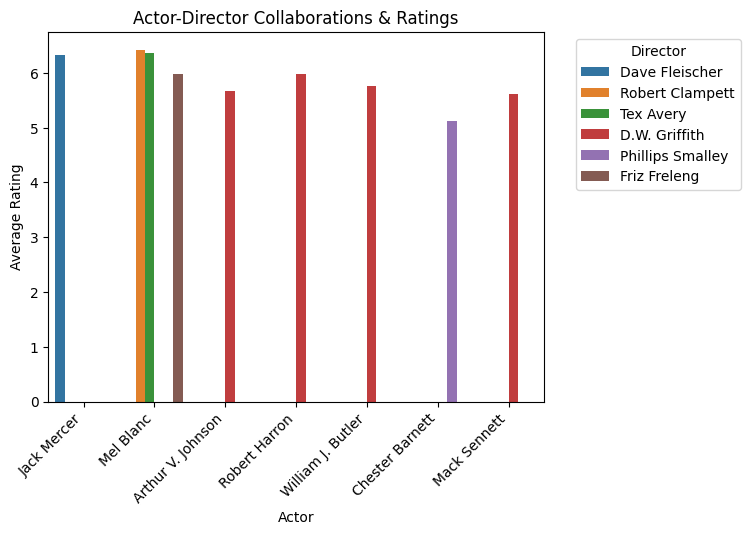

In [42]:
# Plot actor-director collaborations and ratings
sns.barplot(x="actor_name", y="avg_rating", hue="director_name", data=df_final)
plt.xticks(rotation=45, ha="right")
plt.title("Actor-Director Collaborations & Ratings")
plt.xlabel("Actor")
plt.ylabel("Average Rating")
plt.legend(title="Director", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

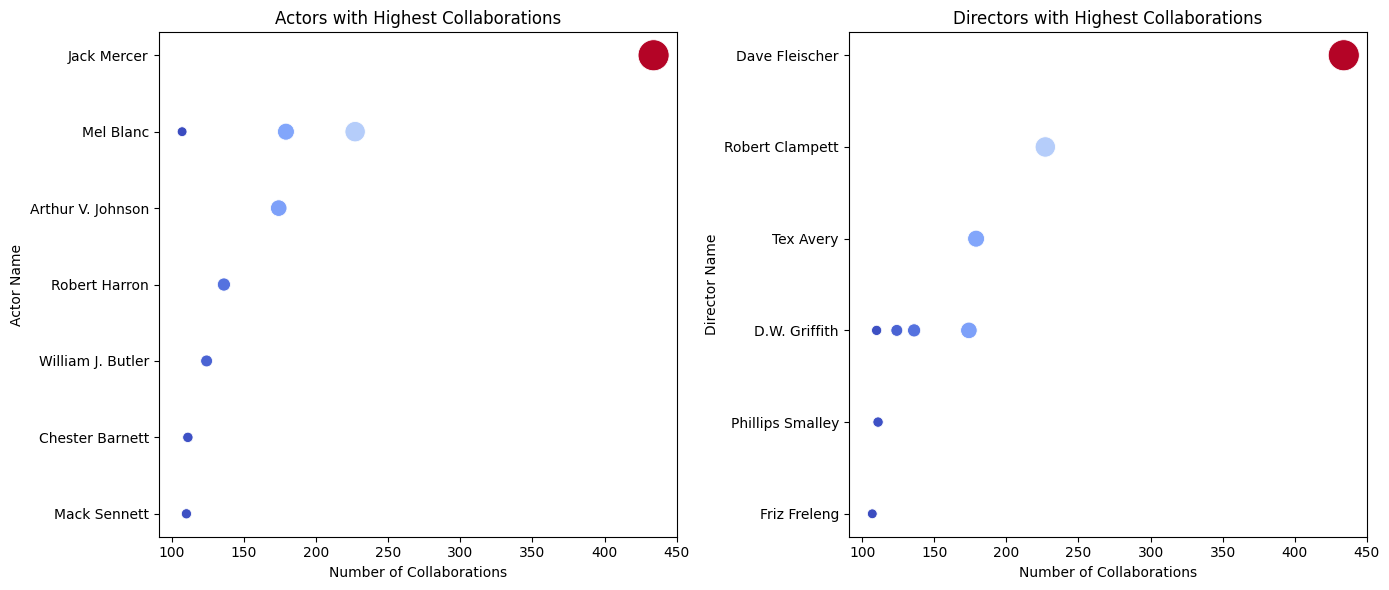

In [43]:
# Plot highly collaborative actors and directors
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot for highly collaborative actors
sns.scatterplot(ax=axes[0], x='collaborations', y='actor_name', 
                size='collaborations', sizes=(50, 500), hue='collaborations', 
                data=df_final, palette='coolwarm', legend=False)
axes[0].set_title('Actors with Highest Collaborations')
axes[0].set_xlabel('Number of Collaborations')
axes[0].set_ylabel('Actor Name')

# Plot for highly collaborative directors
sns.scatterplot(ax=axes[1], x='collaborations', y='director_name', 
                size='collaborations', sizes=(50, 500), hue='collaborations', 
                data=df_final, palette='coolwarm', legend=False)
axes[1].set_title('Directors with Highest Collaborations')
axes[1].set_xlabel('Number of Collaborations')
axes[1].set_ylabel('Director Name')

# Adjust layout
plt.tight_layout()
plt.show()

### Additional PostgreSQL Queries for Future Work

In [45]:
# Reconnect to PostgreSQL database
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="password",
    host="localhost",
    port="5432"
)

In [46]:
# 1. Most Popular Actors (Based on Highest Rated Films)
# Actors with the highest average ratings
query1 = """
WITH ActorRatings AS (
SELECT
    tp.nconst,
    nb.primaryName,
    AVG(tr.averageRating) AS avg_rating
FROM title_principals tp
JOIN title_ratings tr ON tp.tconst = tr.tconst
JOIN name_basics nb ON tp.nconst = nb.nconst
WHERE tp.category = 'actor' OR tp.category = 'actress'
GROUP BY tp.nconst, nb.primaryName
)
SELECT *
FROM ActorRatings
ORDER BY avg_rating DESC
--LIMIT 10;
"""
df1 = pd.read_sql(query1, conn)

# 2. Movie Genre Trends
# a) Most popular genre per year (based on highest rated genre):
query2 = """
WITH GenreRatings AS (
    SELECT
        tb.startYear,
        unnest(string_to_array(tb.genres, ',')) AS genre,
        AVG(tr.averageRating) AS avg_rating
    FROM title_basics tb
    JOIN title_ratings tr ON tb.tconst = tr.tconst
    WHERE tb.startYear IS NOT NULL
    GROUP BY tb.startYear, genre
)
SELECT DISTINCT ON (startYear) startYear, genre, avg_rating
FROM GenreRatings
ORDER BY startYear, avg_rating DESC;
"""
df2 = pd.read_sql(query2, conn)

# 2. Movie Genre Trends
# b) Most common genre per year (based on number of movies made):
query3 = """
WITH GenreCounts AS (
    SELECT
        tb.startYear,
        unnest(string_to_array(tb.genres, ',')) AS genre,
        COUNT(*) AS num_movies
    FROM title_basics tb
    WHERE tb.startYear IS NOT NULL
    GROUP BY tb.startYear, genre
)
SELECT DISTINCT ON (startYear) startYear, genre, num_movies
FROM GenreCounts
ORDER BY startYear, num_movies DESC;
"""
df3 = pd.read_sql(query3, conn)

# Close the connection
conn.close()

/var/folders/0r/zh94ng3s0g9_ftxyg7jzz_p80000gn/T/ipykernel_17661/2805095153.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, conn)
/var/folders/0r/zh94ng3s0g9_ftxyg7jzz_p80000gn/T/ipykernel_17661/2805095153.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, conn)
/var/folders/0r/zh94ng3s0g9_ftxyg7jzz_p80000gn/T/ipykernel_17661/2805095153.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn)


#### 1. Most Popular Actors (Based on Highest Rated Films)

In [47]:
# Actors with the highest average ratings
df1

,nconst,primaryname,avg_rating
0,nm0951402,Flora Zabelle,9.0
1,nm0861401,Lizette Thorne,9.0
2,nm0326378,John Goldsworthy,9.0
3,nm0367362,Will Hartzell,9.0
4,nm0917877,Katrin Weigle,9.0
...,...,...,...
24547,nm0697437,Ricardo Prieto,1.0
24548,nm0206887,Julio Ruiz de Alda,1.0
24549,nm0659735,Elita Panquer,1.0
24550,nm0916089,Dick Webb,1.0


#### 2. Movie Genre Trends

In [48]:
# a) Most popular genre per year (based on highest rated genre):
df2

,startyear,genre,avg_rating
0,1888,Documentary,6.90
1,1889,Documentary,5.00
2,1890,Documentary,4.90
3,1891,Sport,4.90
4,1892,Comedy,6.40
...,...,...,...
133,2021,Documentary,8.26
134,2022,Musical,8.35
135,2023,Biography,8.80
136,2024,War,8.40


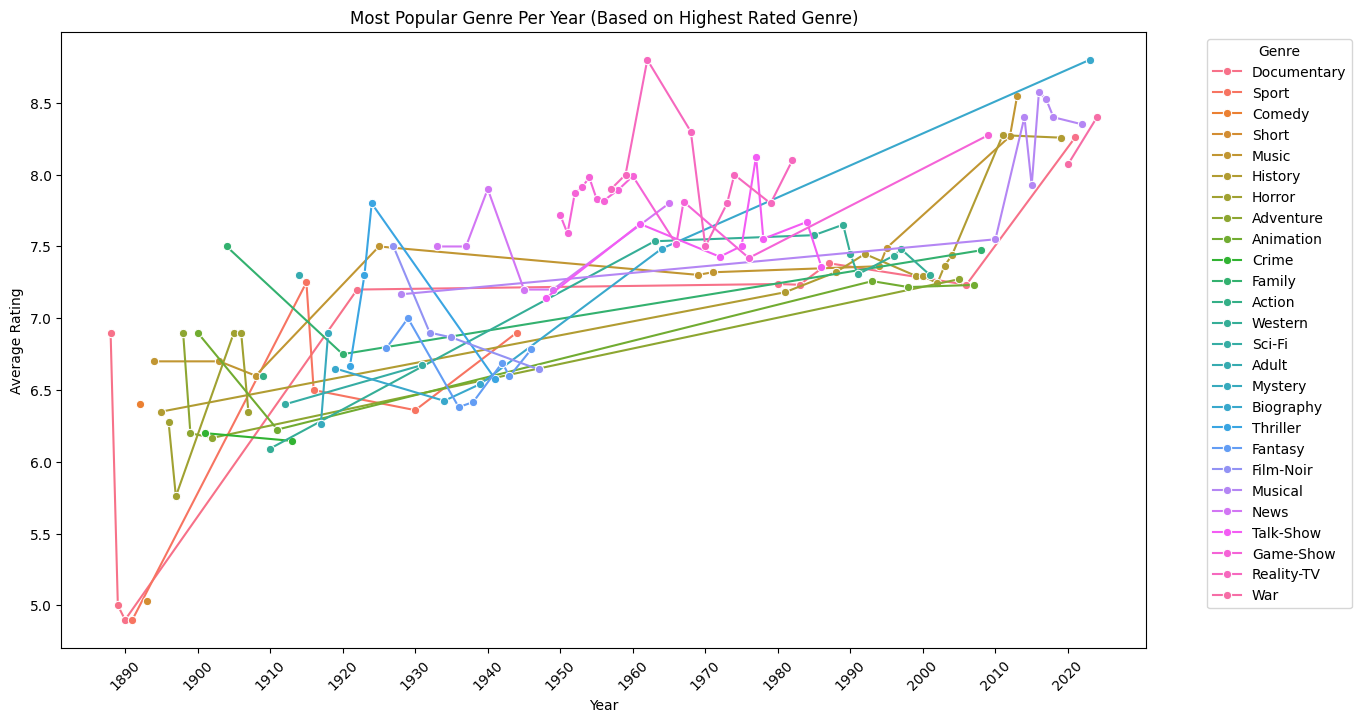

In [49]:
# Plot of popular genres over the years
df2['startyear'] = pd.to_numeric(df2['startyear'], errors='coerce')
plt.figure(figsize=(14, 8))
sns.lineplot(x='startyear', y='avg_rating', hue='genre', data=df2, marker='o')
plt.title('Most Popular Genre Per Year (Based on Highest Rated Genre)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
years = df2['startyear'].unique()
plt.xticks(ticks=[year for year in years if year % 10 == 0], rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [50]:
# b) Most common genre per year (based on number of movies made):
df3

,startyear,genre,num_movies
0,1888,Documentary,2
1,1889,Documentary,1
2,1890,Short,3
3,1891,Short,7
4,1892,Short,7
...,...,...,...
135,2023,Short,17
136,2024,Short,15
137,2025,Talk-Show,12
138,2026,Action,1


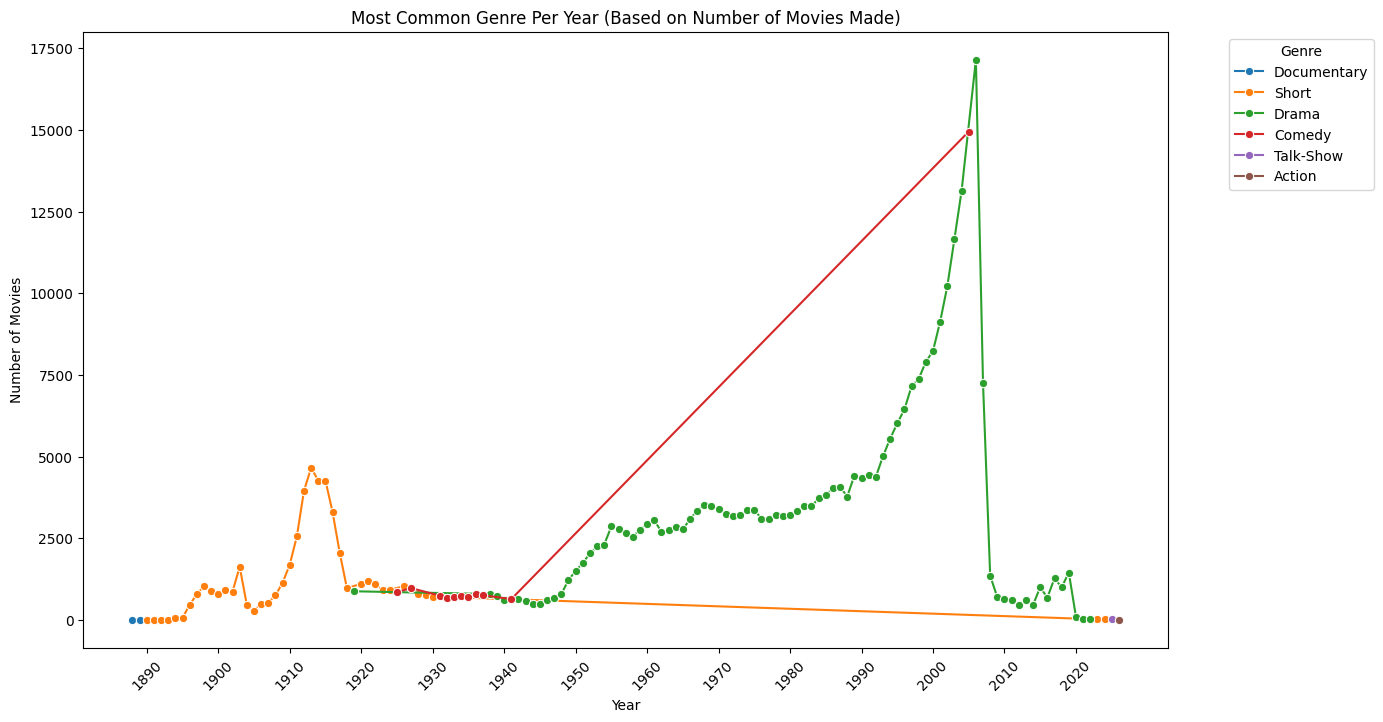

In [51]:
# Plot of popular genres over the years
df3['startyear'] = pd.to_numeric(df3['startyear'], errors='coerce')
plt.figure(figsize=(14, 8))
sns.lineplot(x='startyear', y='num_movies', hue='genre', data=df3, marker='o')
plt.title('Most Common Genre Per Year (Based on Number of Movies Made)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
years = df3['startyear'].unique()
plt.xticks(ticks=[year for year in years if year % 10 == 0], rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()